<a href="https://colab.research.google.com/github/liliayata/liliayata/blob/main/DecisionTree_TitanicPassengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier 


In [ ]:
# Loading the data
train_tp = pd.read_csv("titanic-passengers.csv",sep=";") 
test_tp = pd.read_csv("titanic-passengers.csv",sep=";")
tp=pd.read_csv("titanic-passengers.csv", sep=";")

In [ ]:
full_data = [train_tp, test_tp]

In [ ]:
# Showing overview of the train dataset
train_tp.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S


# **Cleaning data**

#drop missing values


In [ ]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [ ]:
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_tp['Fare'].median())

In [ ]:
# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)


#titles

In [ ]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [ ]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


#Mapping

In [ ]:

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [ ]:

# Feature that tells whether a passenger had a cabin on the Titanic
train_tp['Has_Cabin'] = train_tp["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_tp['Has_Cabin'] = test_tp["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#Convert categorical variable into dummy variables.

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

train_tp["Survived_y"]=labelencoder.fit_transform(train_tp["Survived"])


In [ ]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Survived']
train_tp = train_tp.drop(drop_elements, axis = 1)
test_tp  = test_tp.drop(drop_elements, axis = 1)

#Visualize data

In [ ]:
train_tp.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,Has_Cabin,FamilySize,IsAlone,Survived_y
0,2,1,1,0,1,0,1,0,1,1,0
1,3,1,1,0,0,0,1,1,1,1,0
2,3,1,1,0,0,0,1,0,1,1,0


In [ ]:
train_tp.columns

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Title',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Survived_y'],
      dtype='object')

In [ ]:
train_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      891 non-null    int64
 1   Sex         891 non-null    int64
 2   Age         891 non-null    int64
 3   Parch       891 non-null    int64
 4   Fare        891 non-null    int64
 5   Embarked    891 non-null    int64
 6   Title       891 non-null    int64
 7   Has_Cabin   891 non-null    int64
 8   FamilySize  891 non-null    int64
 9   IsAlone     891 non-null    int64
 10  Survived_y  891 non-null    int64
dtypes: int64(11)
memory usage: 76.7 KB


#Decision Tree


In [ ]:
#features extraction
from sklearn.model_selection import train_test_split
x=train_tp.drop(["Survived_y"], axis=1)
y= train_tp["Survived_y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)


In [ ]:
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(x, y)

In [ ]:
y_pred = clf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.914179104477612


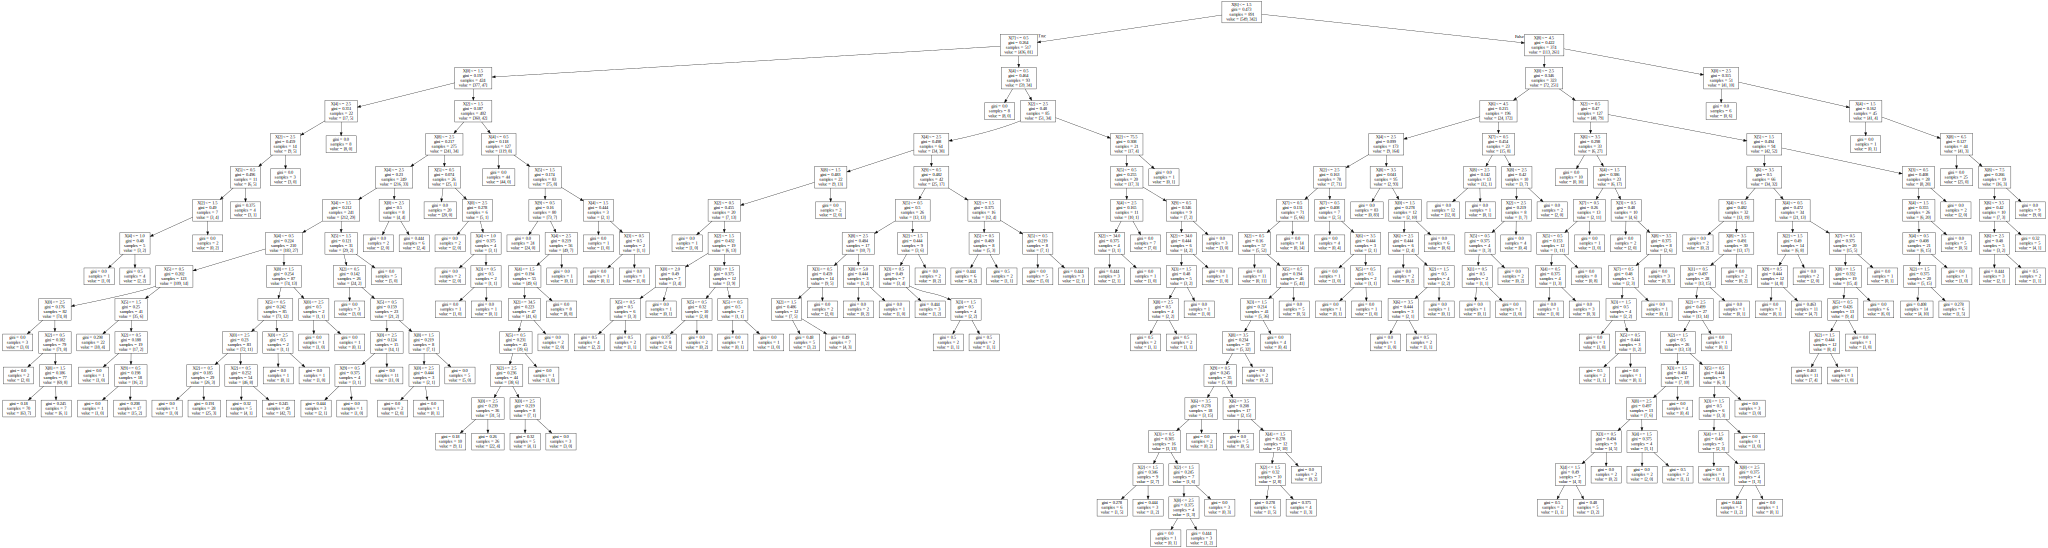

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
dtree=tree.DecisionTreeClassifier(criterion="gini",splitter='random',max_leaf_nodes=10,min_samples_leaf=5, max_depth=5)

#change the parameters


In [ ]:
#Now extract the parameters
parameters_dt = clf.get_params()

#Now change the parameter you want
parameters_dt['max_depth'] = 3  #The maximum depth of the tree.
parameters_dt['max_leaf_nodes']=5 # Best nodes are defined as relative reduction in impurity.
parameters_dt['min_samples_leaf']=3 #The minimum number of samples required to be at a leaf node.

#Now create a new classifier
new_clf = DecisionTreeClassifier(**parameters_dt)


In [ ]:
# Fit the classifier with default hyper-parameters

model = new_clf.fit(x, y)

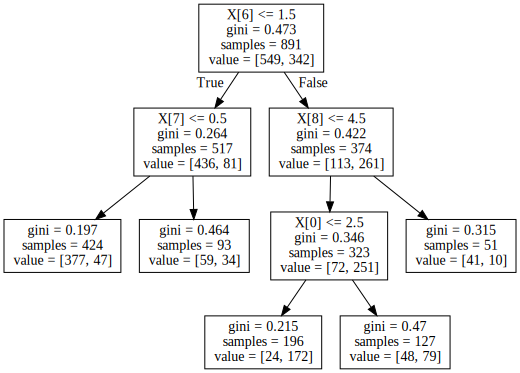

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(new_clf, out_file=None)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
y_p = new_clf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_p))

Accuracy: 0.8507462686567164


the precision has decreased due to the change of parameters, this means that the new values of the parameters are not optimal 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
x=train_tp[['Pclass','Sex','Age','Fare','FamilySize']]
y=train_tp[['Survived_y']]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=30)
clf=RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Acuracy:", metrics.accuracy_score(y_test, y_pred))

Acuracy: 0.8026905829596412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


the precision has decreased even more the random forest chooses features randomly during the training process